In [1]:
#!pip install --user --quiet pomegranate

In [2]:
#!git clone https://github.com/pgmpy/pgmpy

In [3]:
#!cd pgmpy
#!python setup.py install --user

In [4]:
import matplotlib.pyplot as plt
from graphviz import Source
import pandas as pd
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Bayesian Graphical Models (for Hackers)

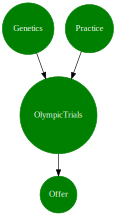

In [5]:
Source(
    """
    digraph {
        node [fontcolor=white shape=circle style=filled color=green]
        size ="3,3";
        Genetics -> OlympicTrials
        Practice -> OlympicTrials
        OlympicTrials -> Offer
    }
    """
)

- joint probability -- fully describe how two or more variables are distibuted simultaneously; P(A=a and B=b)
- conditional -- how prob of A are distrib given a certain value for, say, B: P(A=a | B=b)
- marginal -- averaging over one variable to get the prob distribution of the other; the marginal prob dist of A when A and B are related would be given by $P(a)=\int_B P(a|b)P(b)db$

Bayes Nwtwork is a DAG.
- compact representation of the joint distribution
- observe conditional independence relationships between vertices/random variables

For each node
- you need the distribution in terms of its parent
- if no parent, then the absolute

- each node as a CPD (Conditional Prob Distribution) associated with it
- if the node has parents, the associated CPD represents P(value|parent's value)
- if a node has no parents, the CPD is just P(value), the unconditional prob of that value

In [6]:
import numpy as np
from tqdm import tqdm_notebook as tqdm

Now that we have a network, what can we do with it? We can supply evidence and ask questions -- any questions about any of the nodes; aka **inference**. How? To do this, you don't need to apply any formulas. To quote [Jake Vanderplas](https://www.youtube.com/watch?v=Iq9DzN6mvYA),

> **"if you can write a for loop, then you can do statistics."**

So let's see what we can do with a for loop. To infer, we just
1. write down what we know (if anything),
2. sample randomly (i.e., simulate) for what we don't know
3. and keep track of outcomes we care about.

To sample, we just set up a probability mass function (i.e., a discrete probabilty distribtion) and the associated outcome labels. Then we use `np.random.choice(list_of_possible_outcomes, p=associated_pmf)`.

First we need to set up the data structures for convenience.


In [7]:
genes_pmf = np.array([.2, .8])  # <-- probability mass function for the outcome
genes = ['good', 'bad']

practice_pmf = np.array([.7, .3])   # <-- probability mass function for the outcome
practice = ['yes', 'no']

# indexed by (genes, practice)
olympic_trials_cpd = {
    ('good', 'yes'): np.array([0.5, 0.3, 0.2]),  # <-- pmf for the outcome GIVEN the two inputs
    ('good', 'no'): np.array([0.8, 0.15, 0.05]),
    ('bad', 'yes'): np.array([0.8, 0.1, 0.1]),
    ('bad', 'no'): np.array([0.9, 0.08, 0.02])
}
olympic_trials = ['bad', 'borderline', 'amazing']

# indexed by olympic_trials
offer_cpd = { 
    'bad': np.array([0.95, 0.05]),  # <-- pmf for the outcome GIVEN the input
    'borderline': np.array([0.8, 0.2]),
    'amazing': np.array([0.5, 0.5])
}
offer = ['no', 'yes']

Let's take a look at the conditional probability densities for the performance at the Olympic Trials.

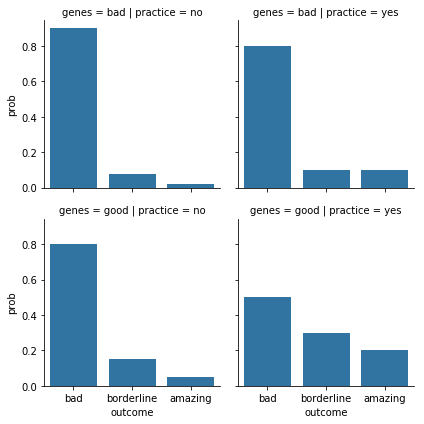

In [8]:
df = pd.DataFrame(olympic_trials_cpd)
df.index = olympic_trials
df = df.stack().stack().reset_index()
df.columns = ['outcome', 'practice', 'genes', 'prob']
g = sns.FacetGrid(df, col='practice', row='genes')
g = g.map(sns.barplot, 'outcome', 'prob', order=olympic_trials)


**If you don't know anything about the person, what is the probability of getting an offer?** Just sample and see how many trials are successful.

In [9]:
got_offer = 0
trials_amazing = 0
n_sims = 100000

for i in tqdm(np.arange(n_sims)):
    
    # sample for genes
    genes_sample = np.random.choice(genes, p=genes_pmf)
    
    # sample for practice time
    practice_sample = np.random.choice(practice, p=practice_pmf)
    
    # given the outcome for genes and practice, sample for olympic trials performance
    olympic_trials_sample = np.random.choice(
        olympic_trials, p=olympic_trials_cpd[(genes_sample, practice_sample)]
    )
    if olympic_trials_sample == 'amazing':
        trials_amazing +=1
    
    # given the outcome for olympic trials performace 
    offer_sample = np.random.choice(offer, p=offer_cpd[olympic_trials_sample])
    if offer_sample == 'yes':
        got_offer += 1

In [10]:
print(got_offer/n_sims)

0.11093


In [11]:
print(trials_amazing/n_sims)

0.09276


**If you have good genetics, what is the probablity of getting an offer?**

In [12]:
got_offer = 0
n_sims = 100000

for i in tqdm(np.arange(n_sims)):
    
    # we know this so it is fixed!
    genes_sample = 'bad'
    
    # sample for practice time
    practice_sample = np.random.choice(practice, p=practice_pmf)
    
    # given the outcome for genes and practice, sample for olympic trials performance
    olympic_trials_sample = np.random.choice(
        olympic_trials, p=olympic_trials_cpd[(genes_sample, practice_sample)]
    )
    
    # given the outcome for olympic trials performace 
    offer_sample = np.random.choice(offer, p=offer_cpd[olympic_trials_sample])
    
    if offer_sample == 'yes':
        got_offer += 1

In [13]:
print(got_offer/n_sims)

0.09924


**The super power of the Bayesian Graphical Model is that we can go upstream.** Let's say that you observe someone who does amazing at the olympic trials, what is the probability that they have good genes? **Note that we did not define the link in the graph in this direction!** That's the amazing thing though: we can do inference on any node.

In [14]:
good_genes = 0
trials_awesome = 0
n_sims = 100000

for i in tqdm(np.arange(n_sims)):
    # sample for genes
    genes_sample = np.random.choice(genes, p=genes_pmf)
    
    # sample for practice time
    practice_sample = np.random.choice(practice, p=practice_pmf)
    
    # given the outcome for genes and practice, sample for olympic trials performance
    olympic_trials_sample = np.random.choice(
        olympic_trials, p=olympic_trials_cpd[(genes_sample, practice_sample)]
    )
    
    # here's the trick: just keep track of the outcomes in the condition we *know*
    if olympic_trials_sample == 'amazing':
        trials_awesome +=1
        if genes_sample == 'good':
            good_genes += 1


In [15]:
print(good_genes/trials_awesome)

0.33355020602906094


In [16]:
good_genes = 0
trials_awesome = 0
n_sims = 100000

for i in tqdm(np.arange(n_sims)):
    # sample for genes
    genes_sample = np.random.choice(genes, p=genes_pmf)
    
    # sample for practice time
    practice_sample = 'no'
    
    # given the outcome for genes and practice, sample for olympic trials performance
    olympic_trials_sample = np.random.choice(
        olympic_trials, p=olympic_trials_cpd[(genes_sample, practice_sample)]
    )
    
    # here's the trick: just keep track of the outcomes in the condition we *know*
    if olympic_trials_sample == 'amazing':
        trials_awesome +=1
        if genes_sample == 'good':
            good_genes += 1


In [17]:
print(good_genes/trials_awesome)

0.38702290076335877


In [18]:
print(trials_awesome/n_sims)

0.0262


# Exact Inference

When you have discrete distributions like this, you don't need to sample. You can get exact inference. That's a bit of a black box (to me), so I did the sampling method first. There are a couple Python packages that do this. Below I work through the problems with `pgmpy`. If you want to use a continuous distribution then you have to sample.

In [19]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

Set up the structure with the flows mapped as pairs (from, to)

In [20]:
olympic_model = BayesianModel([
    ('Genetics', 'OlympicTrials'),
    ('Practice', 'OlympicTrials'),
    ('OlympicTrials', 'Offer')
])

Set up the CPDs

In [21]:
genetics_cpd = TabularCPD(
    variable = 'Genetics',
    variable_card = 2,   # cardinality
    values = [[.2, .8]]   # ['good', 'bad']
)

In [22]:
practice_cpd = TabularCPD(
    variable = 'Practice',
    variable_card = 2,
    values = [[.7, .3]]   # ['yes', 'no']
)

In [23]:
offer_cpd = TabularCPD(
    variable = 'Offer',
    variable_card = 2,
    values = [[0.95, 0.8, 0.5],
              [.05, .2, .5]],
    evidence = ['OlympicTrials'],
    evidence_card = [3]
)

In [24]:
olympic_trials_cpd = TabularCPD(
    variable = 'OlympicTrials',
    variable_card = 3,
    values = [[.5, .8, .8, .9],
              [.3, .15, .1, .08],
              [.2, .05, .1, .02]],
    evidence = ['Genetics', 'Practice'],
    evidence_card = [2,2]
)

In [25]:
olympic_model.add_cpds(genetics_cpd, practice_cpd, offer_cpd, olympic_trials_cpd)

In [26]:
olympic_model.get_cpds()

[<TabularCPD representing P(Genetics:2) at 0x7f8b581e1be0>,
 <TabularCPD representing P(Practice:2) at 0x7f8b581e1d30>,
 <TabularCPD representing P(Offer:2 | OlympicTrials:3) at 0x7f8b581ef198>,
 <TabularCPD representing P(OlympicTrials:3 | Genetics:2, Practice:2) at 0x7f8b581ef3c8>]

In [27]:
# what does Genetics influence
olympic_model.active_trail_nodes('Genetics')

{'Genetics': {'Genetics', 'Offer', 'OlympicTrials'}}

In [28]:
# what is independent?
olympic_model.local_independencies('Genetics')

(Genetics _|_ Offer, Practice, OlympicTrials)

In [29]:
olympic_model.get_independencies()

(Genetics _|_ Practice)
(Genetics _|_ Offer | OlympicTrials)
(Genetics _|_ Offer | Practice, OlympicTrials)
(Practice _|_ Genetics)
(Practice _|_ Offer | OlympicTrials)
(Practice _|_ Offer | Genetics, OlympicTrials)
(Offer _|_ Practice, Genetics | OlympicTrials)
(Offer _|_ Genetics | Practice, OlympicTrials)
(Offer _|_ Practice | Genetics, OlympicTrials)

Inference!

In [30]:
from pgmpy.inference import VariableElimination

In [31]:
olympic_infer = VariableElimination(olympic_model)

In [32]:
# If you knew nothing, what's the probabilty of an offer?
prob_offer = olympic_infer.query(variables = ['Offer', 'Practice', 'Genetics', 'OlympicTrials'])
print(prob_offer['Offer'])
print(prob_offer['Genetics'])
print(prob_offer['Practice'])
print(prob_offer['OlympicTrials'])

+---------+--------------+
| Offer   |   phi(Offer) |
+=========+==============+
| Offer_0 |       0.8898 |
+---------+--------------+
| Offer_1 |       0.1102 |
+---------+--------------+
+------------+-----------------+
| Genetics   |   phi(Genetics) |
+============+=================+
| Genetics_0 |          0.2000 |
+------------+-----------------+
| Genetics_1 |          0.8000 |
+------------+-----------------+
+------------+-----------------+
| Practice   |   phi(Practice) |
+============+=================+
| Practice_0 |          0.7000 |
+------------+-----------------+
| Practice_1 |          0.3000 |
+------------+-----------------+
+-----------------+----------------------+
| OlympicTrials   |   phi(OlympicTrials) |
+=================+======================+
| OlympicTrials_0 |               0.7820 |
+-----------------+----------------------+
| OlympicTrials_1 |               0.1262 |
+-----------------+----------------------+
| OlympicTrials_2 |               0.0918 |
+----

In [33]:
prob_offer_bad_genes = olympic_infer.query(
    variables = ['Offer', 'Practice'],   # <-- what to calculate for output
    evidence = {'Genetics':1})           # <-- what you know; 0 means the index of the outcome [0,1]
print(prob_offer_bad_genes['Offer'])
#print(prob_offer_bad_genes['Practice'])

+---------+--------------+
| Offer   |   phi(Offer) |
+=========+==============+
| Offer_0 |       0.9017 |
+---------+--------------+
| Offer_1 |       0.0983 |
+---------+--------------+


**The real power: go upstream!**

In [34]:
prob_good_genes_if_amazing_olympic_trials = olympic_infer.query(
    variables = ['Genetics'],
    evidence = {'OlympicTrials': 2}   # <-- 2 means the index of the outcome [0,1,2], so "amazing"
)
print(prob_good_genes_if_amazing_olympic_trials['Genetics'])

+------------+-----------------+
| Genetics   |   phi(Genetics) |
+============+=================+
| Genetics_0 |          0.3377 |
+------------+-----------------+
| Genetics_1 |          0.6623 |
+------------+-----------------+


In [35]:
prob_good_genes_if_no_practice_good_olympic_trials = olympic_infer.query(
    variables = ['Genetics'],
    evidence = {'Practice': 0, 'OlympicTrials': 2}
)
print(prob_good_genes_if_no_practice_good_olympic_trials['Genetics'])

+------------+-----------------+
| Genetics   |   phi(Genetics) |
+============+=================+
| Genetics_0 |          0.3333 |
+------------+-----------------+
| Genetics_1 |          0.6667 |
+------------+-----------------+


What's the most probable state for a variable?

In [36]:
olympic_infer.map_query(variables = ['Genetics', 'Offer', 'OlympicTrials'])

{'Genetics': 1, 'Offer': 0, 'OlympicTrials': 0}

Let's try for a continuous variable.

In [37]:
from pgmpy.factors.continuous import ContinuousFactor

In [38]:
from scipy.stats import norm
from pgmpy.factors.distributions import GaussianDistribution

In [39]:
?GaussianDistribution

In [40]:
?ContinuousFactor

In [41]:
genetics_c_cpd = LinearGaussianCPD(
    variable = 'Genetics_C',
    evidence_mean = 500,
    evidence_variance = 50
)

NameError: name 'LinearGaussianCPD' is not defined

In [ ]:
olympic_model_c = BayesianModel([
    ('Genetics_C', 'OlympicTrials'),
    ('Practice', 'OlympicTrials'),
    ('OlympicTrials', 'Offer')
])

In [ ]:
olympic_model_C.add_cpds(genetics_c_cpd, practice_cpd, offer_cpd, olympic_trials_cpd)

# pomegranate

In [ ]:

from pomegranate import (
    BayesianNetwork,
    ConditionalProbabilityTable,
    DiscreteDistribution,
    State
)

In [ ]:
?ConditionalProbabilityTable

https://www.youtube.com/watch?v=KpoNWIiH2ic

- an arrow means conditionally dependent
- direction matters
- if there is no edge, then it represents conditional independence
- intepretable!
- Two tasks
    - inference given incomplete information (uses Belief Propagation)
    - learning dependency structure
    
- User needs to define model and structure
- Then can set various nodes and see *all* the other nodes
- Is this just boolean at each node???

In [ ]:
Source(
    """
    digraph {
        size ="3,3";
        D -> S
        D -> P
        P -> C
    }
    """
)

In [ ]:
day_of_week = DiscreteDistribution(
    {'weekday': 5./7, 'weekend': 2./7}
)

sunny = DiscreteDistribution(
    {'weekday': 0.80, 'weekend': 0.60}
)


In [ ]:
who = ConditionalProbabilityTable([
    ['weekday', 'Alice', 0.90],
    ['weekend', 'Alice', 0.1],
    ['weekday', 'Bob', 0.35],
    ['weekend', 'Bob', 0.65],
    ['weekday', 'Claire', 0.5],
    ['weekend', 'Claire', 0.50]
], [day_of_week])

In [ ]:
correct = DiscreteDistribution(
    {'Alice': 0.8, 'Bob': 0.55, 'Claire': 0.65}
)

In [ ]:
s1 = State(day_of_week, name="day_of_week")
s2 = State(who, name="who")
s3 = State(sunny, name="sunny")
s4 = State(correct, name="correct")

In [ ]:
network = BayesianNetwork("Weather: day of week")
network.add_states(s1, s2, s3, s4)
network.add_transition(s1, s2)
network.add_transition(s1, s3)
network.add_transition(s2, s4)

In [ ]:
network.bake()

In [ ]:
network.predict_proba({'who': 'Bob'})